# Mapas de Vulnerabilidad COVID-19*
## Lima Metropolitana, Perú

### Objetivo

Desarrollar una plataforma de visualización de datos geograficos que soporte la toma de decisiones de instituciones publicas con el objetivo de mitigar los impactos de la crisis del COVID-19.

Los mapas deben estar basados en datos abiertos y replicables a otras ciudados, de modo que permita identificar rápidamente las zonas con una alta concentración de población vulnerable considerando las siguientes dimensiones: accesibilidad vial, nivel socioeconómico, grupo etario, población flotante, densidad poblacional, fuerza laboral, y acceso a servicios básicos.

### Fuentes de datos

- **OpenStreetMap**
- **Censo Nacional 2007**
- **LandScan 2017**
- **TOP 10mil**
- **Dime**


*Este notebook esta basado en [el trabajo de Patricio y Tony para la ciudad de Quito](https://vulnerabilidad-codigo.netlify.com/)

### Dependencias

In [1]:
import geopandas as gpd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import shapely
import pandas as pd
import plotly.graph_objects as go
import requests
from h3 import h3
from scipy.spatial import cKDTree
from tqdm import tqdm

# Notebook setup
%matplotlib inline
sns.set_style('dark')
tqdm.pandas()

/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/.env/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



## Descarga de datos

### Límites de la ciudad

El primer paso será conseguir los limites de la ciudad, para Lima Metropolitana se deben combinar los limites de Lima y Callao. Fuente: [Nominatim](https://nominatim.openstreetmap.org/)

In [2]:
# Fuente de datos
url = 'https://nominatim.openstreetmap.org/search.php'
parameters = {
    'polygon_geojson': '1',
    'format': 'geojson'
}

In [3]:
# Descarga de datos de Lima
posicion = 2 # La posición en que aparece entre los resultados de Nominatim 
parameters['q'] = "Lima, Peru"

response = requests.get(url, params=parameters)
all_results = response.json()
lima_gdf = gpd.GeoDataFrame.from_features(all_results['features'])
lima_ = lima_gdf.iloc[posicion:posicion+1, :] # Limites de Lima provincia

In [4]:
# Descarga de datos de Lima
parameters['q'] = "Callao, Peru"
posicion = 1 # La posición en que aparece entre los resultados de Nominatim 

response = requests.get(url, params=parameters)
all_results = response.json()
callao_gdf = gpd.GeoDataFrame.from_features(all_results['features'])
callao_ =  callao_gdf.iloc[posicion:posicion+1, :] # Limites de Callao provincia constitucional

In [5]:
# Combinacion de limites de lima y callao
lima_metropolitana = gpd.GeoDataFrame(geometry=[pd.concat((lima_, callao_)).unary_union])

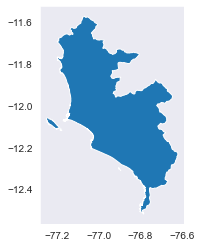

In [6]:
# Visualizamos los datos
lima_metropolitana.plot()
plt.show()

### Nivel Socioeconómico y Población por manzana, Fuente: Censo Nacional 2007 INEI

In [7]:
# Cargamos los datos
manzanas = gpd.read_file('inputs/manzanas_nse/mz_lima_region.shp')

In [8]:
manzanas.head()

IDMANZANA CODZONA CODMZNA  CLASIFICAC  UBIGEO NOMBREMZNA  \
0    150728    None    None           1  150728       None   
1    150728    None    None           1  150728       None   
2    150728    None    None           1  150728       None   
3    150728    None    None           1  150728       None   
4    150728    None    None           1  150728       None   

                          URBANIZACI NSE07  POB07  VIV07  LONGITUDE  \
0                               None  None      0      0 -76.671052   
1  ASOC PUEBLO NUEVO DE BUENOS AIRES  None      0      0 -76.672482   
2  ASOC PUEBLO NUEVO DE BUENOS AIRES  None      0      0 -76.673467   
3  ASOC PUEBLO NUEVO DE BUENOS AIRES  None      0      0 -76.673106   
4  ASOC PUEBLO NUEVO DE BUENOS AIRES  None      0      0 -76.672936   

    LATITUDE                                           geometry  
0 -11.916842  POLYGON ((-76.67379 -11.91608, -76.67329 -11.9...  
1 -11.914053  POLYGON ((-76.67319 -11.91445, -76.67318 -11.9...  
2 -11.914446  POLYGON ((-76.67368 -11.91441, -76.67341 -11.9...  
3 -11.914645  POLYGON ((-76.67351 -11.91473, -76.67321 -11.9...  
4 -11.914838  POLYGON ((-76.67335 -11.91492, -76.67267 -11.9...

In [9]:
manzanas['NSE07'].unique()

array([None, 'ME', 'MB', 'MA', 'BA', 'AL', '0.'], dtype=object)

In [10]:
# Proporcion de valores perdidos por variable
manzanas.isna().sum() / manzanas.shape[0]

IDMANZANA     0.000000
CODZONA       0.181153
CODMZNA       0.181124
CLASIFICAC    0.000000
UBIGEO        0.000000
NOMBREMZNA    0.557573
URBANIZACI    0.230322
NSE07         0.386055
POB07         0.000000
VIV07         0.000000
LONGITUDE     0.000000
LATITUDE      0.000000
geometry      0.000000
dtype: float64

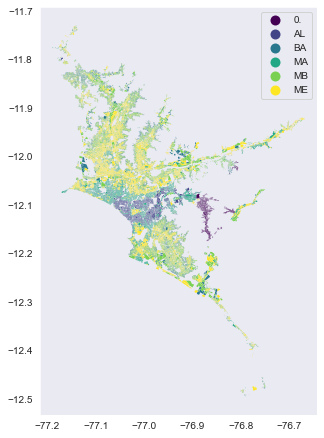

In [11]:
# Distribucion espacial de los niveles socioeconomicos
manzanas.plot(column='NSE07', cmap='viridis', linewidth=0, legend=True, figsize=(5, 7.5))
plt.show()

### Acceso a instalaciones de alimentos

In [12]:
# Generate Lima bbox as overpass param
bbox = list(lima_metropolitana.geometry[0].bounds)
bbox_string = f'{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}'

# Define query for Food Access Facilities in Lima
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[timeout:120][out:json][bbox];
(
  node["amenity"="market_place"];
  node["shop"~"supermarket|kiosk|mall|convenience|butcher|greengrocer"];
);
out body geom;
"""

# Request data
response = requests.get(overpass_url, params={'data': overpass_query,
                                              'bbox': bbox_string})
data = response.json()

In [13]:
# Create GeoDataFrame
food_access_pois_df = pd.DataFrame.from_dict(data['elements'])
food_access_pois_geometry = gpd.points_from_xy(food_access_pois_df['lon'], food_access_pois_df['lat'])

food_access_pois_gdf = gpd.GeoDataFrame(food_access_pois_df, geometry=food_access_pois_geometry)

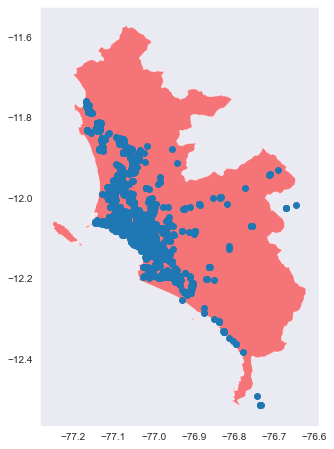

In [14]:
# Visualize data for sanity check
ax = lima_metropolitana.plot(color='red', alpha=0.5, figsize=(5,75))
food_access_pois_gdf.plot(ax=ax)
plt.show()

## Procesamiento 
Se utilizará la librería [H3](https://h3geo.org/) de Uber para implementar un sistema de grillas que facilite la unificación de capas de datos geo-espaciales

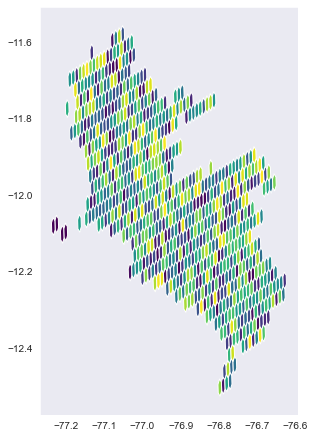

In [15]:
resolution = 8

# Polyfill the city boundaries
h3_centroids = list()
h3_polygons = list()
h3_indexes = list()

lima_polygons = lima_metropolitana.explode().reset_index(drop=True) # Get every polygon in Multipolygon shape

for ix, geo in lima_polygons.iterrows():
    hexagons = h3.polyfill(geo[0].__geo_interface__, res=resolution)
    for hexagon in hexagons:
        h3_centroids.append(shapely.geometry.Point(h3.h3_to_geo(hexagon)))
        h3_polygons.append(shapely.geometry.Polygon(h3.h3_to_geo_boundary(hexagon)))
        h3_indexes.append(hexagon)
        
# Create hexagon dataframe         
lima_metropolitana_h = gpd.GeoDataFrame(h3_indexes, geometry=h3_polygons).drop_duplicates()
lima_metropolitana_centroids = gpd.GeoDataFrame(h3_indexes, geometry=h3_centroids).drop_duplicates()
lima_metropolitana_centroids.crs = 'EPSG:4326'
# Visualize result for sanity check 
lima_metropolitana_h.plot(cmap='viridis', figsize=(5,7.5))
plt.show()

### Niveles socioconómicos por hexágono

In [16]:
# Intersect Hex Point with CT Polygon
dfh_nse = gpd.tools.sjoin(manzanas, lima_metropolitana_centroids, how="inner")

# Add value to hexagons geodataframe
lima_metropolitana_h.loc[dfh_nse['index_right'],'NSE07'] = dfh_nse['NSE07'].values 

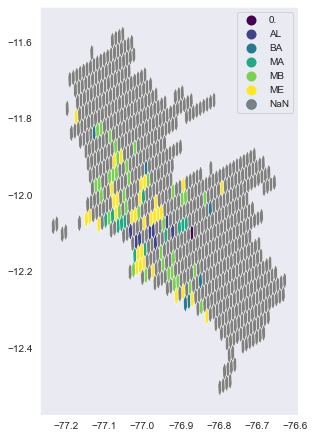

In [17]:
# Visualize results
lima_metropolitana_h.plot(column='NSE07', cmap='viridis', linewidth=0.5, legend=True, figsize=(5,7.5), missing_kwds={'color':'grey'})
plt.show()

### Instalación de alimentos más cercana a cada hexágono

La instalación del software para la adquisición de la grilla de calles y puesta en marcha del servicio de ruteo se encuentra detallado en este [notebook](https://vulnerabilidad-codigo.netlify.com/).

In [19]:
# Create KDTree to search for spatial nearest neighboard
kdtree = cKDTree(data=food_access_pois_gdf[['lon','lat']].values)

Utilizaremos el centroide de cada hexágono como estimación de su posición para hacer la búsqueda.

In [20]:
# nn_ff: nearest_food_facility
lima_metropolitana_centroids['nn_ff'] = lima_metropolitana_centroids.geometry.progress_apply(lambda geom: kdtree.query([geom.x, geom.y])[1])

100%|██████████| 759/759 [00:00<00:00, 7708.23it/s]


Ahora vamos a calcular la duración y la distancia de un viaje caminando desde el centro de un hexágono hacia un lugar de compra de alimento, Fuente: [OSRM](http://project-osrm.org/)

In [21]:
def osrm_routes(origin, destination, profile):
    try:
        orig = f'{origin.x},{origin.y}'
        dest = f'{destination.x},{destination.y}'
        url = f'http://localhost:5000/route/v1/{profile}/{orig};{dest}' # Local osrm server
        response = requests.get(url, params={'overview': 'false'})
        data = response.json()['routes'][0]
        return [data['distance'], data['duration']]
    except Exception as err:
        pass

In [22]:
# Walking distance and duration
lima_metropolitana_centroids[['dist_nn_ff_walk', 'dur_nn_ff_walk']] = lima_metropolitana_centroids.progress_apply(
    lambda row: osrm_routes(
        origin=row.geometry, 
        destination = food_access_pois_gdf.iloc[row['nn_ff']]['geometry'],
        profile = 'walking'
    ),
    result_type='expand',
    axis=1,
)

100%|██████████| 759/759 [00:07<00:00, 108.16it/s]


In [23]:
# Check missing values
lima_metropolitana_centroids[['dist_nn_ff_walk']].isna().sum()

dist_nn_ff_walk    3
dtype: int64

In [24]:
# Check descriptive statistics
(lima_metropolitana_centroids[['dist_nn_ff_walk', 'dur_nn_ff_walk']] / [1000, 360]).describe()  # meters to km & seconds to hours

dist_nn_ff_walk  dur_nn_ff_walk
count       756.000000      756.000000
mean         15.387673       30.790736
std          24.277579       48.564911
min           0.002500        0.005278
25%           1.922825        3.845625
50%           5.430150       10.863472
75%          14.836150       29.672361
max         188.699200      377.478889

In [25]:
# Treat outliers
outliers_top = lima_metropolitana_centroids['dur_nn_ff_walk'].quantile(0.9)
outliers_ix = lima_metropolitana_centroids['dur_nn_ff_walk'] > outliers_top
lima_metropolitana_centroids.loc[outliers_ix,'dur_nn_ff_walk'] = outliers_top

In [26]:
# Add values to hexagons GeoDataFrame
lima_metropolitana_h.loc[lima_metropolitana_centroids.index,'dist_nn_ff_walk'] = lima_metropolitana_centroids['dist_nn_ff_walk'].values
lima_metropolitana_h.loc[lima_metropolitana_centroids.index,'dur_nn_ff_walk'] = lima_metropolitana_centroids['dur_nn_ff_walk'].values / 60 # seconds to minutes

In [27]:
# Generamos cortes en la variable duración del viaje
lima_metropolitana_h['dur_nn_ff_walk_bins'] = pd.cut(
    lima_metropolitana_h['dur_nn_ff_walk'], 
    bins=[0, 15, 30, 45, 60, 90, 120, lima_metropolitana_h['dur_nn_ff_walk'].max()], 
    labels=["menos de 15 minutos", "15 a 30 minutos", "30 a 45 minutos", 
            "45 a 60 minutos", "60 a 90 minutos", "90 a 120 minutos", "más dos horas"]
)

In [28]:
# Verificamos la cantidad de celdas por corte
lima_metropolitana_h['dur_nn_ff_walk_bins'].value_counts()

más dos horas          253
menos de 15 minutos    146
60 a 90 minutos        105
15 a 30 minutos         79
30 a 45 minutos         76
45 a 60 minutos         53
90 a 120 minutos        44
Name: dur_nn_ff_walk_bins, dtype: int64

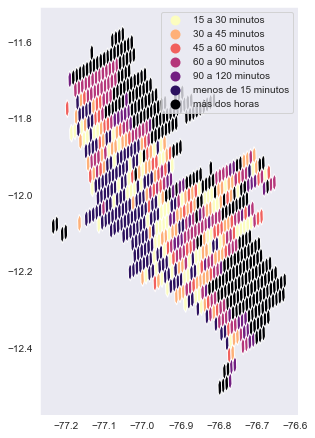

In [29]:
# Visualize results
lima_metropolitana_h.plot(column='dur_nn_ff_walk_bins', cmap='magma_r', legend=True, figsize=(5,7.5))
plt.show()

## Identificación de zonas de riesgo

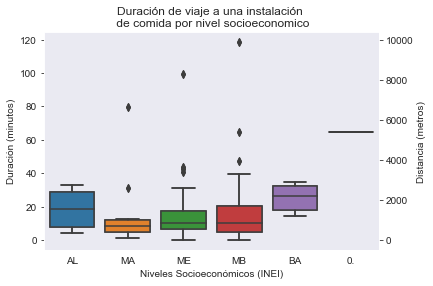

In [30]:
# Grafico 
g = sns.boxplot(x="NSE07", y="dur_nn_ff_walk", order=['AL','MA','ME','MB','BA','0.'], 
                   data=lima_metropolitana_h);
g.set_title('Duración de viaje a una instalación \n de comida por nivel socioeconomico')
g.set_ylabel('Duración (minutos)')
g.set_xlabel('Niveles Socioeconómicos (INEI)')

ax = g.twinx()
g1 = sns.boxplot(x="NSE07", y="dist_nn_ff_walk", order=['AL','MA','ME','MB','BA','0.'],ax=ax ,
                   data=lima_metropolitana_h);
g1.set_ylabel('Distancia (metros)')
plt.show()

Sobre la base de los graficos consideraremos **población en riesgo** a quienes se encuentren en el **nivel socioeconómico medio bajo (MB) o bajo (BA)** y tengan una **distancia y duracion de la instalación de alimentos más cercana mayor a 2 km y 30 minutos**, respectivamente.

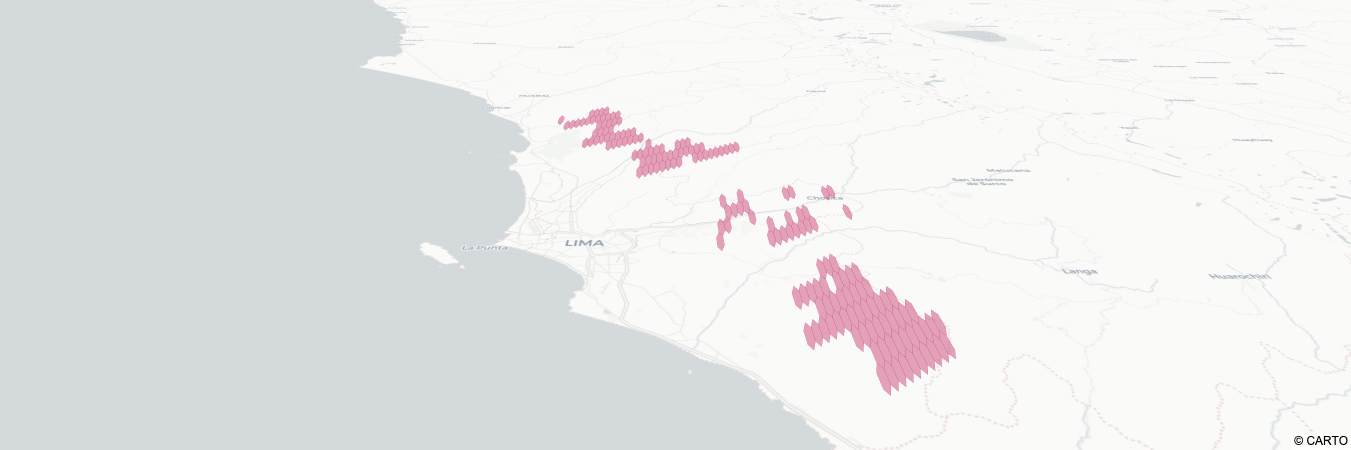

In [31]:
filtro_pob_en_riesgo = (lima_metropolitana_h['dist_nn_ff_walk'] > 20000) & (lima_metropolitana_h['dur_nn_ff_walk'] > 35)

fig = go.Figure(
    go.Choroplethmapbox(
        geojson=lima_metropolitana_h[['geometry']].__geo_interface__,
        locations=lima_metropolitana_h[filtro_pob_en_riesgo].index.values.tolist(),
        z=np.ones(shape=lima_metropolitana_h.shape[0]), # Just one color
        showscale=False,
        marker_opacity=0.5,
        marker_line_width=0,
    )
)
fig.update_layout(
    mapbox_style="carto-positron", 
    mapbox_zoom=9, 
    mapbox_pitch=60, 
    mapbox_bearing=0, 
    mapbox_center = {"lat": lima_metropolitana.centroid.y[0], 
                     "lon": lima_metropolitana.centroid.x[0]})

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

f = go.FigureWidget(fig, 'lima')
f.show()

In [ ]:
# Hasta aqui he avanzado
stop

In [ ]:
markets_in_h3 = gpd.sjoin(geomarkets, lima_metropolitana, how='inner', op='within')

In [ ]:
markets_in_h3

In [ ]:
markets_count = markets_in_h3[['index_right','ID']].groupby(by='index_right').count()

In [ ]:
markets_count_values = markets_count.values
markets_count_ixs = markets_count.index

In [ ]:
lima_metropolitana.loc[markets_count_ixs,'markets_count'] = markets_count_values

In [ ]:
lima_metrepolitana_h3 = lima_metropolitana.__geo_interface__

In [ ]:
geomarkets

In [ ]:
!export MAPBOX_API_KEY='pk.eyJ1IjoiY2xhdWRpbzk3IiwiYSI6ImNqbzM2NmFtMjB0YnUzd3BvenZzN3QzN3YifQ.heZHwQTY8TWhuO0u2-BxxA'

In [ ]:
import pydeck as pdk

# 2014 locations of car accidents in the UK
UK_ACCIDENTS_DATA = ('https://raw.githubusercontent.com/uber-common/'
                     'deck.gl-data/master/examples/3d-heatmap/heatmap-data.csv')

# Define a layer to display on a map
layer = pdk.Layer(
    'HexagonLayer',
    pd.DataFrame(geomarkets),
    get_position=['longitude', 'latitude'],
    auto_highlight=True,
    elevation_scale=20,
    pickable=True,
    elevation_range=[0, 200],
    extruded=True,                 
    coverage=1)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=-72,
    latitude=-12,
    zoom=6,
    min_zoom=5,
    max_zoom=15,
    pitch=40.5,
    bearing=-27.36)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html('demo.html')

In [ ]:
fig = go.Figure(
    go.Choroplethmapbox(
        geojson=lima_metropolitana_h[['geometry']].__geo_interface__,
        locations=list(range(len(lima_metropolitana_h))), 
        z=lima_metropolitana_h['dist_nn_ff_walk'], 
        marker_opacity=0.5,
        marker_line_width=0
    )
)
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=10, mapbox_pitch=60, mapbox_bearing=0, mapbox_center = {"lat": -12, "lon": -77})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
f = go.FigureWidget(fig, 'lima')
f.show()

In [ ]:

# Acceso a Agua 
sin_serv_agua = gpd.read_file('inputs/data_pob_servicios_agua_.geojson')

In [ ]:
manzanas_geojson = manzanas.__geo_interface__

In [ ]:
manzanas_geojson = manazanas_geojson

In [ ]:
manzanas_geojson['features'][1]['geometry']

In [ ]:
h3_polyfill = h3.polyfill(manzanas_geojson['features'][1]['geometry'], 15, geo_json_conformant=True)

In [ ]:
h3_polyfill = list(h3_polyfill)

In [ ]:
h3_boundary = h3.h3_to_geo_boundary(h3_polyfill[0])

In [ ]:
from shapely.geometry import Polygon

In [ ]:
h3_boundary

In [ ]:
Polygon(h3_boundary)

In [ ]:
import plotly.

### Puntos de Concentración de Personas

In [ ]:
# Población Flotante por intervalo de tiempo, Datos Telcos


### Empleabilidad

In [ ]:
# Trabajadores por Tipo de Empresa, UP
empresas = pd.read_csv('inputs/empresas_lima.csv')

### Riesgo Desastres Naturales

In [ ]:
# Materiales de Viviendas, Censo 2017 INEI

# Densidad Poblacional, Censo 2017 INEI / FB Humanitarian Data
manzanas
# Riesgo Sísmico, Ministerio de Vivienda PNUD 2010
